# Model calibrations using ML

## Structure

# We apply the inverse map approach to solve the calibration problem

## Authors

Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

## Extract data

In [1]:
import os
os.chdir("..\Data")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
f = gzip.GzipFile('rBergomiTrainSet.txt.gz', "r")
dat=np.load(f)
print(dat.shape)
xx=dat[:,:4]
yy=dat[:,4:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(40000, 92)
(40000, 4)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    yy, xx, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [8]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)

# Convolutional nets

## We use a custom activation function to make sure that model parameters are within admisible bounds

### (No need to run the training optimal parameters are stored in a .h5 file)

In [9]:
import keras
from keras.layers import Activation
from keras.layers import Dense
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
input1 = keras.layers.Input(shape=(len(maturities),len(strikes),1))
x1 = keras.layers.Convolution2D(16, (3, 3),activation='elu')(input1)
input2=keras.layers.Input(shape=(6,9, 16) )
x2=keras.layers.MaxPooling2D(pool_size=(2,2))(x1)
input3=keras.layers.Input(shape=(3,4, 16) )
x3=keras.layers.Flatten()(x2)
x4=keras.layers.Dense(50,activation = 'elu')(x3)
ub=scale.transform(np.array([[0.26,4,1.0,0.5]]))[0]
lb=scale.transform(np.array([[0.001,0.01,-1.0,0.001]]))[0]
def custom_activation1(x):
    return (K.tanh(x))*(ub[0] - lb[0]) *0.5 + (ub[0] + lb[0])*0.5
def custom_activation2(x):
    return (K.tanh(x))*(ub[1] - lb[1]) *0.5 + (ub[1] + lb[1])*0.5
def custom_activation3(x):
    return K.tanh(x)*(ub[2] - lb[2]) *0.5 + (ub[3] + lb[2])*0.5
def custom_activation4(x):
    return K.tanh(x)*(ub[3] - lb[3]) *0.5 + (ub[3] + lb[3])*0.5
get_custom_objects().update({'custom_activation1': Activation(custom_activation1)})
get_custom_objects().update({'custom_activation2': Activation(custom_activation2)})
get_custom_objects().update({'custom_activation3': Activation(custom_activation3)})
get_custom_objects().update({'custom_activation4': Activation(custom_activation4)})
seq1 = Dense(1, activation = 'custom_activation1')(x4)
seq2 = Dense(1, activation = 'custom_activation2')(x4)
seq3 = Dense(1, activation = 'custom_activation3')(x4)
seq4 = Dense(1, activation = 'custom_activation4')(x4)

acum = keras.layers.merge.concatenate([seq1, seq2, seq3,seq4], axis=-1)

model = keras.models.Model(inputs=input1, outputs=acum)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 11, 1)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 9, 16)     160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 3, 4, 16)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 192)          0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
dense_1 (D

In [10]:
from keras.callbacks import EarlyStopping
# Configure Early Stopping
patience = 25
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1, 
                          patience=patience)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model.compile(loss = root_mean_squared_error, optimizer = "adam")
A=x_train_transform.reshape(len(x_train_transform),len(maturities),len(strikes),1)
B=x_test_transform.reshape(len(x_test_transform),len(maturities),len(strikes),1)
model.fit(A,y_train_transform, batch_size=64,validation_data = (B,y_test_transform),epochs = 200, verbose = True,shuffle=1,callbacks=[earlystop])

Train on 34000 samples, validate on 6000 samples
Epoch 1/200
34000/34000 [==============================] - 3s 89us/step - loss: 0.2882 - val_loss: 0.1925
Epoch 2/200
34000/34000 [==============================] - 2s 60us/step - loss: 0.1866 - val_loss: 0.1704
Epoch 3/200
34000/34000 [==============================] - 2s 61us/step - loss: 0.1625 - val_loss: 0.1715
Epoch 4/200
34000/34000 [==============================] - 2s 71us/step - loss: 0.1430 - val_loss: 0.1331
Epoch 5/200
34000/34000 [==============================] - 2s 56us/step - loss: 0.1265 - val_loss: 0.1284
Epoch 6/200
34000/34000 [==============================] - 2s 58us/step - loss: 0.1148 - val_loss: 0.1298
Epoch 7/200
34000/34000 [==============================] - 2s 56us/step - loss: 0.1073 - val_loss: 0.1097
Epoch 8/200
34000/34000 [==============================] - 2s 56us/step - loss: 0.1008 - val_loss: 0.1117
Epoch 9/200
34000/34000 [==============================] - 2s 56us/step - loss: 0.0957 - val_loss: 0.09

34000/34000 [==============================] - 2s 58us/step - loss: 0.0198 - val_loss: 0.0188
Epoch 154/200
34000/34000 [==============================] - 2s 63us/step - loss: 0.0203 - val_loss: 0.0246
Epoch 155/200
34000/34000 [==============================] - 2s 57us/step - loss: 0.0201 - val_loss: 0.0244
Epoch 156/200
34000/34000 [==============================] - 2s 58us/step - loss: 0.0196 - val_loss: 0.0185
Epoch 157/200
34000/34000 [==============================] - 2s 63us/step - loss: 0.0192 - val_loss: 0.0187
Epoch 158/200
34000/34000 [==============================] - 2s 61us/step - loss: 0.0198 - val_loss: 0.0196
Epoch 159/200
34000/34000 [==============================] - 2s 60us/step - loss: 0.0196 - val_loss: 0.0215
Epoch 160/200
34000/34000 [==============================] - 2s 62us/step - loss: 0.0191 - val_loss: 0.0189
Epoch 161/200
34000/34000 [==============================] - 2s 63us/step - loss: 0.0195 - val_loss: 0.0231
Epoch 162/200
34000/34000 [===============

In [11]:
model.save_weights('InverseMapNNWeights.h5')

In [ ]:
model.load_weights('InverseMapNNWeights.h5')

# Check relative errors per parameter

No handles with labels found to put in legend.


average=  0.004214628453473489


No handles with labels found to put in legend.


average=  0.007201319918837849


No handles with labels found to put in legend.


average=  0.022294493322943476


No handles with labels found to put in legend.


average=  0.014446982871101383


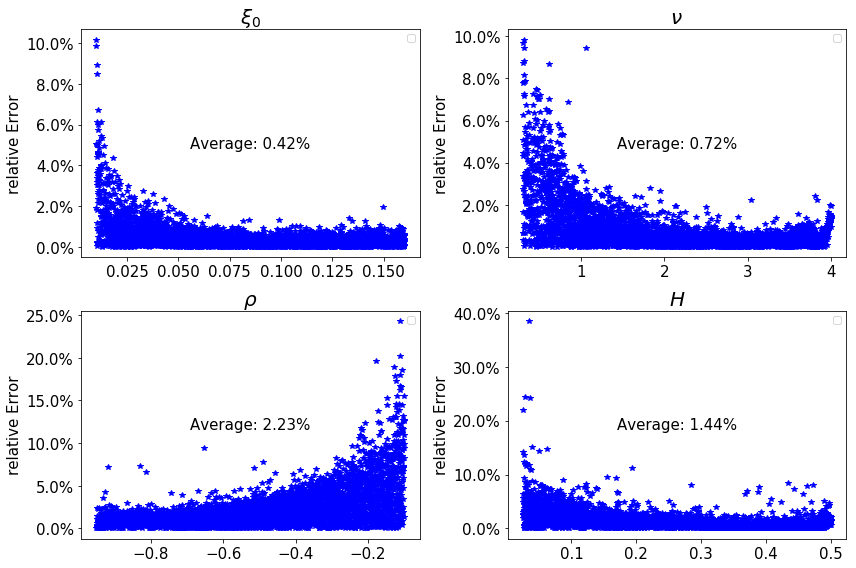

In [12]:
import matplotlib.ticker as mtick
titles=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
average=np.zeros(5000)
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    for i in range(5000):
        y=scale.inverse_transform(y_test_transform[i])[u]
        approx=scale.inverse_transform(model.predict(x_test_transform[i].reshape(1,len(maturities),len(strikes),1)))[0][u]
        plt.plot(y,100*np.abs(approx-y)/np.abs(y),'b*')
        average[i]=np.abs(approx-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.5, 'Average: %1.2f%%'%np.mean(100*average), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

    print("average= ",np.mean(average))
plt.tight_layout()
plt.savefig('InverseMapRelativeErrors.png', dpi=300)
plt.show()